# Pooled, Unpooled and Hierarchial Regression using the Iris dataset

In [28]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
print(f"Running on PyMC v{pm.__version__}")

df = pd.read_csv(r'../../Downloads/iris.csv')
df

Running on PyMC v3.11.2


sepal_length  sepal_width  petal_length  petal_width           class
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

In [29]:
df.corr()

# we will do petal_width ~ petal_length

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

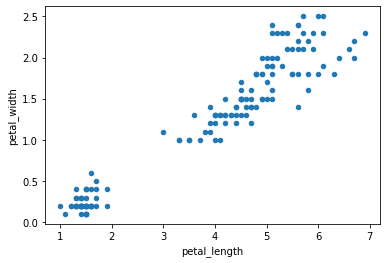

In [3]:
df.plot(kind='scatter', x='petal_length', y='petal_width')

In [30]:
class_id, classes = pd.factorize(df['class'])
coords = {
    "classes": classes,
    "observation": np.arange(df.shape[0]),
}

# Pooled model

In [5]:
with pm.Model(coords=coords) as pooled_model:
    pl = pm.Data('petal_length', df.petal_length)
    
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal("Intercept", 0, sigma=5)
    b = pm.Normal("beta", 0, sigma=5)

    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = pm.Deterministic('mu', a+b*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma, observed=y, dims="observation")
    
    pooled_trace = pm.sample(tune=1500, draws=500, cores=2, return_inferencedata=True, model=pooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_500 tune and 500 draw iterations (3_000 + 1_000 draws total) took 34 seconds.


0, dim: observation, 150 =? 150


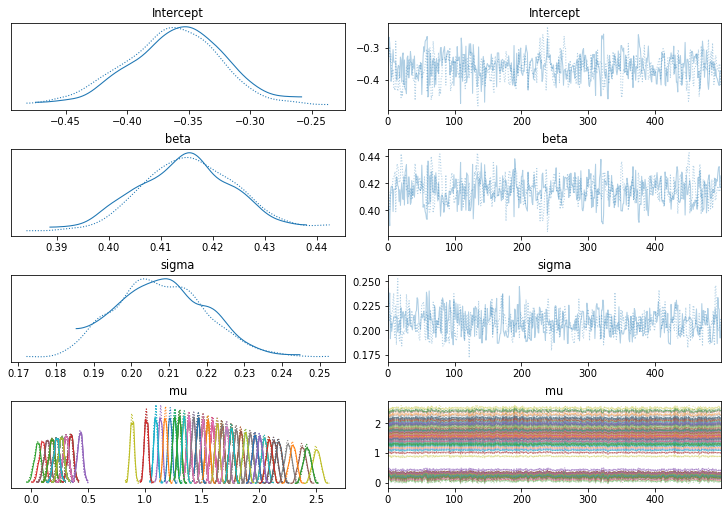

In [6]:
az.plot_trace(pooled_trace, figsize=(10, 7));

In [7]:
pm.summary(pooled_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept -0.361  0.039  -0.440   -0.293      0.002    0.001     475.0   
beta       0.415  0.009   0.399    0.433      0.000    0.000     505.0   
sigma      0.208  0.012   0.186    0.229      0.000    0.000     592.0   
mu[0]      0.220  0.028   0.161    0.268      0.001    0.001     481.0   
mu[1]      0.220  0.028   0.161    0.268      0.001    0.001     481.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu[145]    1.798  0.022   1.759    1.838      0.001    0.001     770.0   
mu[146]    1.715  0.021   1.679    1.753      0.001    0.001     789.0   
mu[147]    1.798  0.022   1.759    1.838      0.001    0.001     770.0   
mu[148]    1.881  0.023   1.840    1.924      0.001    0.001     750.0   
mu[149]    1.756  0.021   1.719    1.796      0.001    0.001     780.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept   475.0     470.0     425.0   1.01  
beta        505.0     505.0     513.0   1.01  
sigma       592.0     578.0     509.0   1.01  
mu[0]       467.0     477.0     441.0   1.01  
mu[1]       467.0     477.0     441.0   1.01  
...           ...       ...       ...    ...  
mu[145]     768.0     773.0     605.0   1.01  
mu[146]     787.0     794.0     642.0   1.01  
mu[147]     768.0     773.0     605.0   1.01  
mu[148]     748.0     750.0     608.0   1.01  
mu[149]     777.0     781.0     642.0   1.01  

[153 rows x 11 columns]

In [8]:
xi = np.linspace(np.min(df.petal_length), np.max(df.petal_length), 150)
with pooled_model:
    pm.set_data({"petal_length": xi})
    pp_y = pm.sample_posterior_predictive(pooled_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(602.0470588235295, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

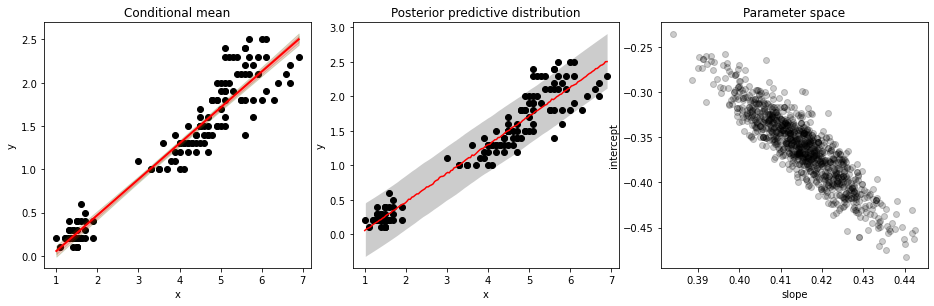

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
fig.tight_layout()
ax[0].scatter(df.petal_length, df.petal_width, color="k")

post = pooled_trace.posterior.stack(sample=("chain", "draw"))
xi = xr.DataArray(np.linspace(np.min(df.petal_length), np.max(df.petal_length), 150), dims=["x_plot"])
y = post.Intercept + post.beta * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
ax[0].fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="r", edgecolor="g"
)
ax[0].fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="r", edgecolor="g"
)
# conditional mean
ax[0].plot(xi, region.sel(quantile=0.5), "r", linewidth=2)
# formatting
ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

ax[1].scatter(df.petal_length, df.petal_width, color="k")
# posterior mean and HDI's
ax[1].plot(xi, np.mean(pp_y, axis=(0, 1)), "r")
az.plot_hdi(
    xi,
    pp_y,
    color="k",
    fill_kwargs={"alpha": 0.2, "linewidth": 0},
    ax=ax[1],
)

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")


ax[2].scatter(
    pooled_trace.posterior.beta.stack(sample=("chain", "draw")),
    pooled_trace.posterior.Intercept.stack(sample=("chain", "draw")),
    color="k",
    alpha=0.2,
)


ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")

# Unpooled model

In [10]:
with pm.Model(coords=coords) as unpooled_model:
    pl = pm.Data('petal_length', df.petal_length, dims='observation')
    flower = pm.Data("flower", class_id, dims="observation")
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal("Intercept", 0, sigma=5, dims='classes')
    b = pm.Normal("beta", 0, sigma=5, dims='classes')

    sigma = pm.HalfNormal('sigma', sd=1, dims='classes')
    
    mu = pm.Deterministic('mu', a[flower]+b[flower]*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma[flower], observed=y, dims="observation")
    
    unpooled_trace = pm.sample(tune=1500, draws=500, cores=2, return_inferencedata=True, model=unpooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_500 tune and 500 draw iterations (3_000 + 1_000 draws total) took 55 seconds.


0, dim: observation, 150 =? 150


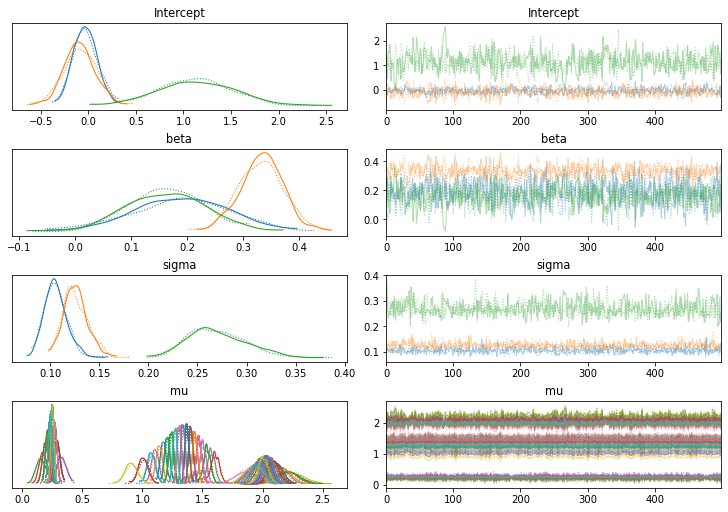

In [11]:
az.plot_trace(unpooled_trace, figsize=(10, 7));

In [12]:
pm.summary(unpooled_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept[0] -0.031  0.126  -0.260    0.209      0.005    0.004     593.0   
Intercept[1] -0.089  0.170  -0.385    0.240      0.007    0.005     522.0   
Intercept[2]  1.138  0.387   0.412    1.827      0.018    0.013     470.0   
beta[0]       0.188  0.086   0.034    0.354      0.004    0.003     578.0   
beta[1]       0.332  0.040   0.251    0.398      0.002    0.001     529.0   
...             ...    ...     ...      ...        ...      ...       ...   
mu[145]       1.971  0.046   1.882    2.049      0.002    0.001     618.0   
mu[146]       1.939  0.054   1.834    2.031      0.002    0.002     550.0   
mu[147]       1.971  0.046   1.882    2.049      0.002    0.001     618.0   
mu[148]       2.003  0.040   1.927    2.075      0.001    0.001     910.0   
mu[149]       1.955  0.050   1.858    2.037      0.002    0.001     580.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
Intercept[0]   443.0     605.0     483.0   1.00  
Intercept[1]   504.0     520.0     453.0   1.00  
Intercept[2]   449.0     477.0     501.0   1.00  
beta[0]        578.0     593.0     456.0   1.00  
beta[1]        529.0     522.0     481.0   1.00  
...              ...       ...       ...    ...  
mu[145]        615.0     630.0     569.0   1.00  
mu[146]        545.0     555.0     579.0   1.00  
mu[147]        615.0     630.0     569.0   1.00  
mu[148]        908.0     910.0     825.0   1.01  
mu[149]        575.0     579.0     592.0   1.00  

[159 rows x 11 columns]

In [13]:
xi = [np.linspace(df.loc[df['class'] == i].petal_length.min(), df.loc[df['class'] == i].petal_length.max(), 50) for i in classes]
g = [np.ones(50) * i for i, _ in enumerate(classes)]
xi, g = np.concatenate(xi), np.concatenate(g)
with unpooled_model:
    pm.set_data({"petal_length": xi, "flower": g.astype(int)})
    pp_y = pm.sample_posterior_predictive(unpooled_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(602.0470588235295, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

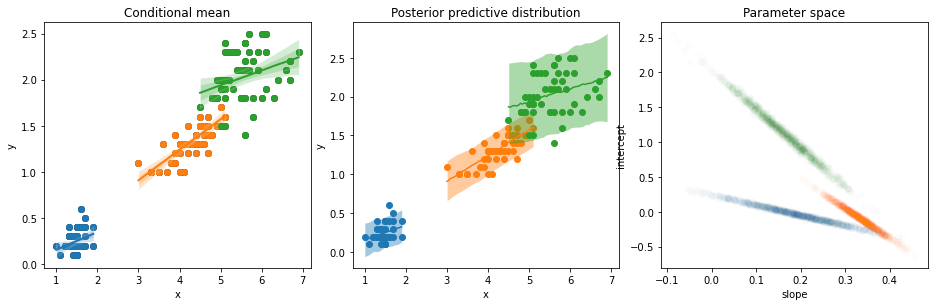

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
fig.tight_layout()
ax[0].scatter(df.petal_length, df.petal_width, color="k")

for i, groupname in enumerate(classes):
    ax[0].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    post = unpooled_trace.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(df.loc[df['class'] == groupname].petal_length.min(), df.loc[df['class'] == groupname].petal_length.max(), 50),
        dims=["x_plot"]
    )
    y = post.Intercept.sel(classes=groupname) + post.beta.sel(classes=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")


for i, groupname in enumerate(classes):
    ax[1].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    ax[1].plot(xi[g == i], np.mean(pp_y[:, :, g == i], axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

for i, _ in enumerate(classes):
    ax[2].scatter(
        unpooled_trace.posterior.beta.stack(sample=("chain", "draw"))[i, :],
        unpooled_trace.posterior.Intercept.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
        rasterized=True,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")

# Hierarchical Model

In [36]:
with pm.Model(coords=coords) as hierarchical_model:
    intercept_mu = pm.Normal('intercept_mu', 0, sigma=5)
    intercept_sigma = pm.HalfNormal('intercept_sigma', sd=5)
    slope_mu = pm.Normal('slope_mu', 1, sigma=5)
    slope_sigma = pm.HalfNormal('slope_sigma', sd=5)
    
    pl = pm.Data('petal_length', df.petal_length, dims='observation')
    flower = pm.Data('flower', class_id, dims='observation')
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal('Intercept', mu=intercept_mu, sigma=intercept_sigma, dims='classes')
    b = pm.Normal('beta', mu=slope_mu, sigma=slope_sigma, dims='classes')

    sigma = pm.HalfNormal('sigma', sd=10, dims='classes')
    
    mu = pm.Deterministic('mu', a[flower]+b[flower]*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma[flower], observed=y, dims='observation')
    
    hierarchical_trace = pm.sample(tune=2000, draws=500, cores=2, target_accept=.99, return_inferencedata=True, model=hierarchical_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept, slope_sigma, slope_mu, intercept_sigma, intercept_mu]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 500 draw iterations (4_000 + 1_000 draws total) took 207 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: observation, 150 =? 150


array([[<AxesSubplot:title={'center':'intercept_mu'}>,
        <AxesSubplot:title={'center':'intercept_mu'}>],
       [<AxesSubplot:title={'center':'slope_mu'}>,
        <AxesSubplot:title={'center':'slope_mu'}>],
       [<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'intercept_sigma'}>,
        <AxesSubplot:title={'center':'intercept_sigma'}>],
       [<AxesSubplot:title={'center':'slope_sigma'}>,
        <AxesSubplot:title={'center':'slope_sigma'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

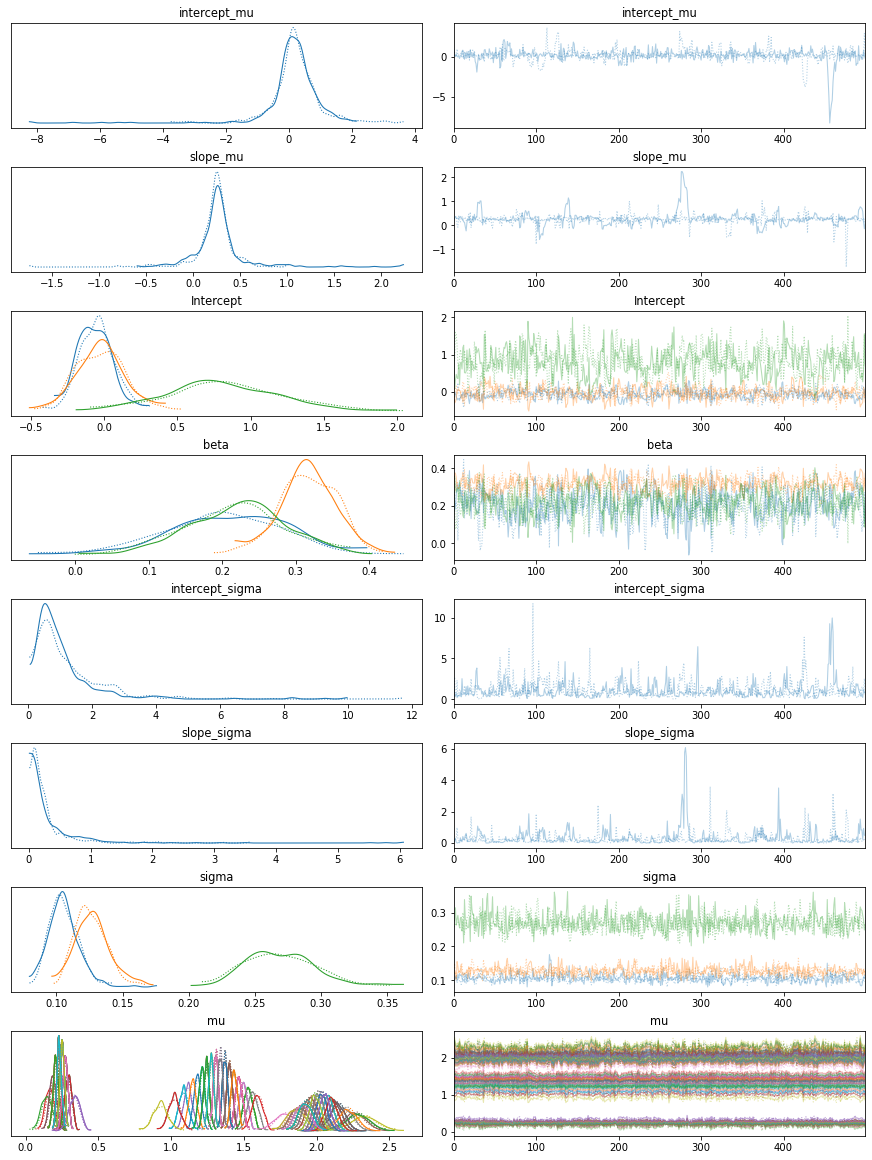

In [37]:
az.plot_trace(hierarchical_trace)

In [38]:
xi = [np.linspace(df.loc[df['class'] == i].petal_length.min(), df.loc[df['class'] == i].petal_length.max(), 50) for i in classes]
g = [np.ones(50) * i for i, _ in enumerate(classes)]
xi, g = np.concatenate(xi), np.concatenate(g)
# Do the posterior prediction
with hierarchical_model:
    pm.set_data({"petal_length": xi, "flower": g.astype(int)})
    pp_y = pm.sample_posterior_predictive(hierarchical_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(553.6588235294118, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

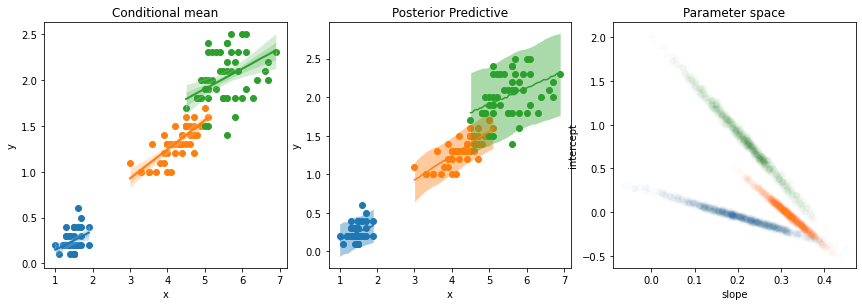

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()
for i, groupname in enumerate(classes):
    ax[0].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    post = hierarchical_trace.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(df.loc[df['class'] == groupname].petal_length.min(), df.loc[df['class'] == groupname].petal_length.max(), 50),
        dims=["x_plot"]
    )
    y = post.Intercept.sel(classes=groupname) + post.beta.sel(classes=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

for i, groupname in enumerate(classes):
    ax[1].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    ax[1].plot(xi[g == i], np.mean(pp_y[:, :, g == i], axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior Predictive")

for i, _ in enumerate(classes):
    ax[2].scatter(
        hierarchical_trace.posterior.beta.stack(sample=("chain", "draw"))[i, :],
        hierarchical_trace.posterior.Intercept.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")